# 1 - Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [7]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import jaxquantum.codes as jqtb
from jax import jit, grad, vmap
import jax.numpy as jnp
import numpy as np
from math import prod
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


from tqdm import tqdm

import jax
import optax
import functools
import datetime


import sys
sys.path.append("..")

from state_prep_opt import *

# 2 - Settings

In [ ]:
settings = {
    "measure": None,
    "blocks": 5,
    "batch_size": 500,
    "epochs": 1000,
    "learning_rate": 5e-3,
    "N": 40,
    "state": {
        "mode": "squeeze",
        "squeezing_dB": 8 
    },
    "N_large": 200,
    "bounds": {
        "lower": [-1,-1,-4,-4],
        "upper": [1,1,4,4]
    },
    "random_seed": 35,
    "reg_strength": 5e-1,
    "reg_mode": 'avg',
    "minimize_metric": False
}

def generate_state(settings, large=False):
    z = jqt.squeezing_dB_to_linear(settings["state"]["squeezing_dB"])
    N = settings["N" if not large else "N_large"]
    target_state_cavity = jqt.squeeze(N, z) @ jqt.basis(N, 0)
    return target_state_cavity

target_state_cavity = generate_state(settings, large=False)
settings["target_state_cavity"] = target_state_cavity
settings["target_state"] = jqt.basis(2,0) ^ target_state_cavity

date_str = datetime.datetime.now().strftime("%Y%m%d_h%Hm%Ms%S")
settings["data_filename"] = f"data/{date_str}_{settings['state']['mode']}_state_prep.npz"

In [ ]:
jqt.plot_qfunc(settings["target_state"], jnp.linspace(-3,3,200))

# 4 - Batch Gradient Descent

In [ ]:
# Option 2: random initialization

# Parameters
key = jax.random.PRNGKey(settings["random_seed"])  # Initialize a random key
B = settings["batch_size"] # Batch size
num_blocks = settings["blocks"]
lower_bounds = jnp.array(settings["bounds"]["lower"])  # Define the lower bounds for each axis
upper_bounds = jnp.array(settings["bounds"]["upper"])    # Define the upper bounds for each axis
random_initial_params = jax.random.uniform(
    key, shape=(B, 4, num_blocks), minval=lower_bounds[:, None], maxval=upper_bounds[:, None]
)

In [ ]:
# Functions


# Warm-up
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"], settings["reg_mode"], settings["reg_strength"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

# Should be faster
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"], settings["reg_mode"], settings["reg_strength"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

In [ ]:
history = optimize(random_initial_params, settings)

In [ ]:
fids_history = history["fids"]
metric_batch_history = history["metric_batch"]
params_history = history["params"]
metric_history = history["metric"]

In [ ]:
log_infid_history = jnp.log10(1-fids_history)
best_final_fid_batch_indx = jnp.argmin(log_infid_history[-1,:])
best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
fidelity_best_fid = fids_history[best_fid_epoch_indx, best_fid_batch_indx]
metric_best_fid = jnp.array(metric_batch_history)[best_fid_epoch_indx, best_fid_batch_indx]

In [ ]:
best_metric_epoch_indx, best_metric_batch_indx = jnp.unravel_index(jnp.argmin(jnp.array(metric_batch_history)), jnp.array(metric_batch_history).shape)
metric_best_metric = jnp.array(metric_batch_history)[best_metric_epoch_indx, best_metric_batch_indx]
fidelity_best_metric = jnp.array(fids_history)[best_metric_epoch_indx, best_metric_batch_indx]

In [ ]:
if settings["minimize_metric"] == False:
    best_params = params_history[best_fid_epoch_indx, best_fid_batch_indx]
else:
    best_params = params_history[best_metric_epoch_indx, best_metric_batch_indx]
best_params = np.round(best_params, 6)
best_params = jnp.array([best_params[0]%1, best_params[1]%1, best_params[2], best_params[3]])
best_params = best_params[:,:]
np.savez(
    settings["data_filename"], 
    settings=settings, 
    best_params=best_params,
    history={
        "params": params_history,
        "fids": fids_history,
        "metrics": metric_history
    }
)    

In [ ]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5,4))
ax.plot(jnp.log10(1-fids_history), linestyle='-', linewidth=0.1)
ax.plot(jnp.log10(1-fids_history[:,best_metric_batch_indx]), linestyle='-', linewidth=1, color='red', label=f"Lowest Loss: $\\mathcal{{F}}={fidelity_best_metric*100:.1f}\%$, $\\mathcal{{L}}={metric_best_metric:.2f}$")
ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=1, color='blue', label=f"Lowest Infidelity: $\\mathcal{{F}}={fidelity_best_fid*100:.1f}\%$, $\\mathcal{{L}}={metric_best_fid:.2f}$")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$\log_{10}$(1-Fidelity)")
# ax.set_title(f"GKP (Δ={gkp_qubit.params['delta']}) State Preparation")
ax.legend(fontsize=6)
fig.suptitle(settings["data_filename"], fontsize=6)
fig.tight_layout()

In [ ]:
pts = jnp.linspace(-3, 3, 50)
jqt.plot_wigner(target_state_cavity, pts)

In [ ]:
pts = jnp.linspace(-3, 3, 50)
prepared_state = run_circuit(params_history[best_metric_epoch_indx, best_metric_batch_indx], settings["N"])
jqt.plot_wigner(prepared_state, pts)

# 5 - Plotting

In [9]:
fpath = r"/orcd/home/002/shanjha/github/data/20250703_h18m39s25_gkp_state_prep_minusX.npz"
file_name=fpath.split("/")[-1]
data=np.load(fpath, allow_pickle=True)
optimal_instructions = data["best_params"]

best_params = jnp.array([optimal_instructions[0], optimal_instructions[1], optimal_instructions[2], optimal_instructions[3]])

def generate_state(settings, large=False):
    N = settings["N"] if not large else settings["N_large"]
    gkp = jqtb.GKPQubit({"delta": settings["state"]["delta"], "N": N})
    return gkp.basis[settings["state"]["logical_state"]]

settings = data["settings"][()]
settings["target_state"] = generate_state(settings)

In [10]:
def run_circuit_errors(params, N, measure=None):
    gammas_x = 2*jnp.pi*params[0]
    gammas_y = 2*jnp.pi*params[1]
    betas_re = params[2]
    betas_im = params[3]

    betas = betas_re + 1j*betas_im
    
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    for i in range(len(gammas_x)):
        cirq.append(jqtc.Rx(gammas_x[i]), 0)
        cirq.append(jqtc.Ry(gammas_y[i]), 0)
        cirq.append(jqtc.CD(N, betas[i]), [0, 1])
        cirq.append(jqtc.D(N, (0.04 - 0.03j)/2.5*betas[i]), 1)
        cirq.append(jqtc.Rx(jnp.pi), 0)
    
    if measure == 'x':
        cirq.append(jqtc.MX_plus(), 0, default_simulate_mode="kraus")
        cirq.append(jqtc.Ry(-jnp.pi/2), 0)
        initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
        res = jqtc.simulate(cirq, initial_state, mode="default")
        return res[-1][-1]/res[-1][-1].trace()
        
    if measure == 'z':
        cirq.append(jqtc.MZ_plus(), 0, default_simulate_mode="kraus")
        initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
        res = jqtc.simulate(cirq, initial_state, mode="default")
        return res[-1][-1]/res[-1][-1].trace()
        
    initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
    res = jqtc.simulate(cirq, initial_state, mode="default")

    return res[-1][-1].unit()

Best parameters: 
 [[ 0.6997    0.41364   0.075049  0.347733  0.141864  0.740268  0.816067]
 [ 0.749151  0.342381  0.085207  0.836043  0.928036  0.947822  0.748806]
 [-1.619372 -0.901525 -0.167361 -0.702379  1.131138  0.054319 -0.117756]
 [-0.105047 -0.512531  1.362054 -0.194143 -0.316677  0.313275  0.002376]]


Text(0.5, 1.02, '20250703_h18m39s25_gkp_state_prep_minusX.npz, $\\vert gkp,-x\\rangle,$ $\\mathcal{F}=0.980$, $N_B=7$, $\\beta=0.5$')

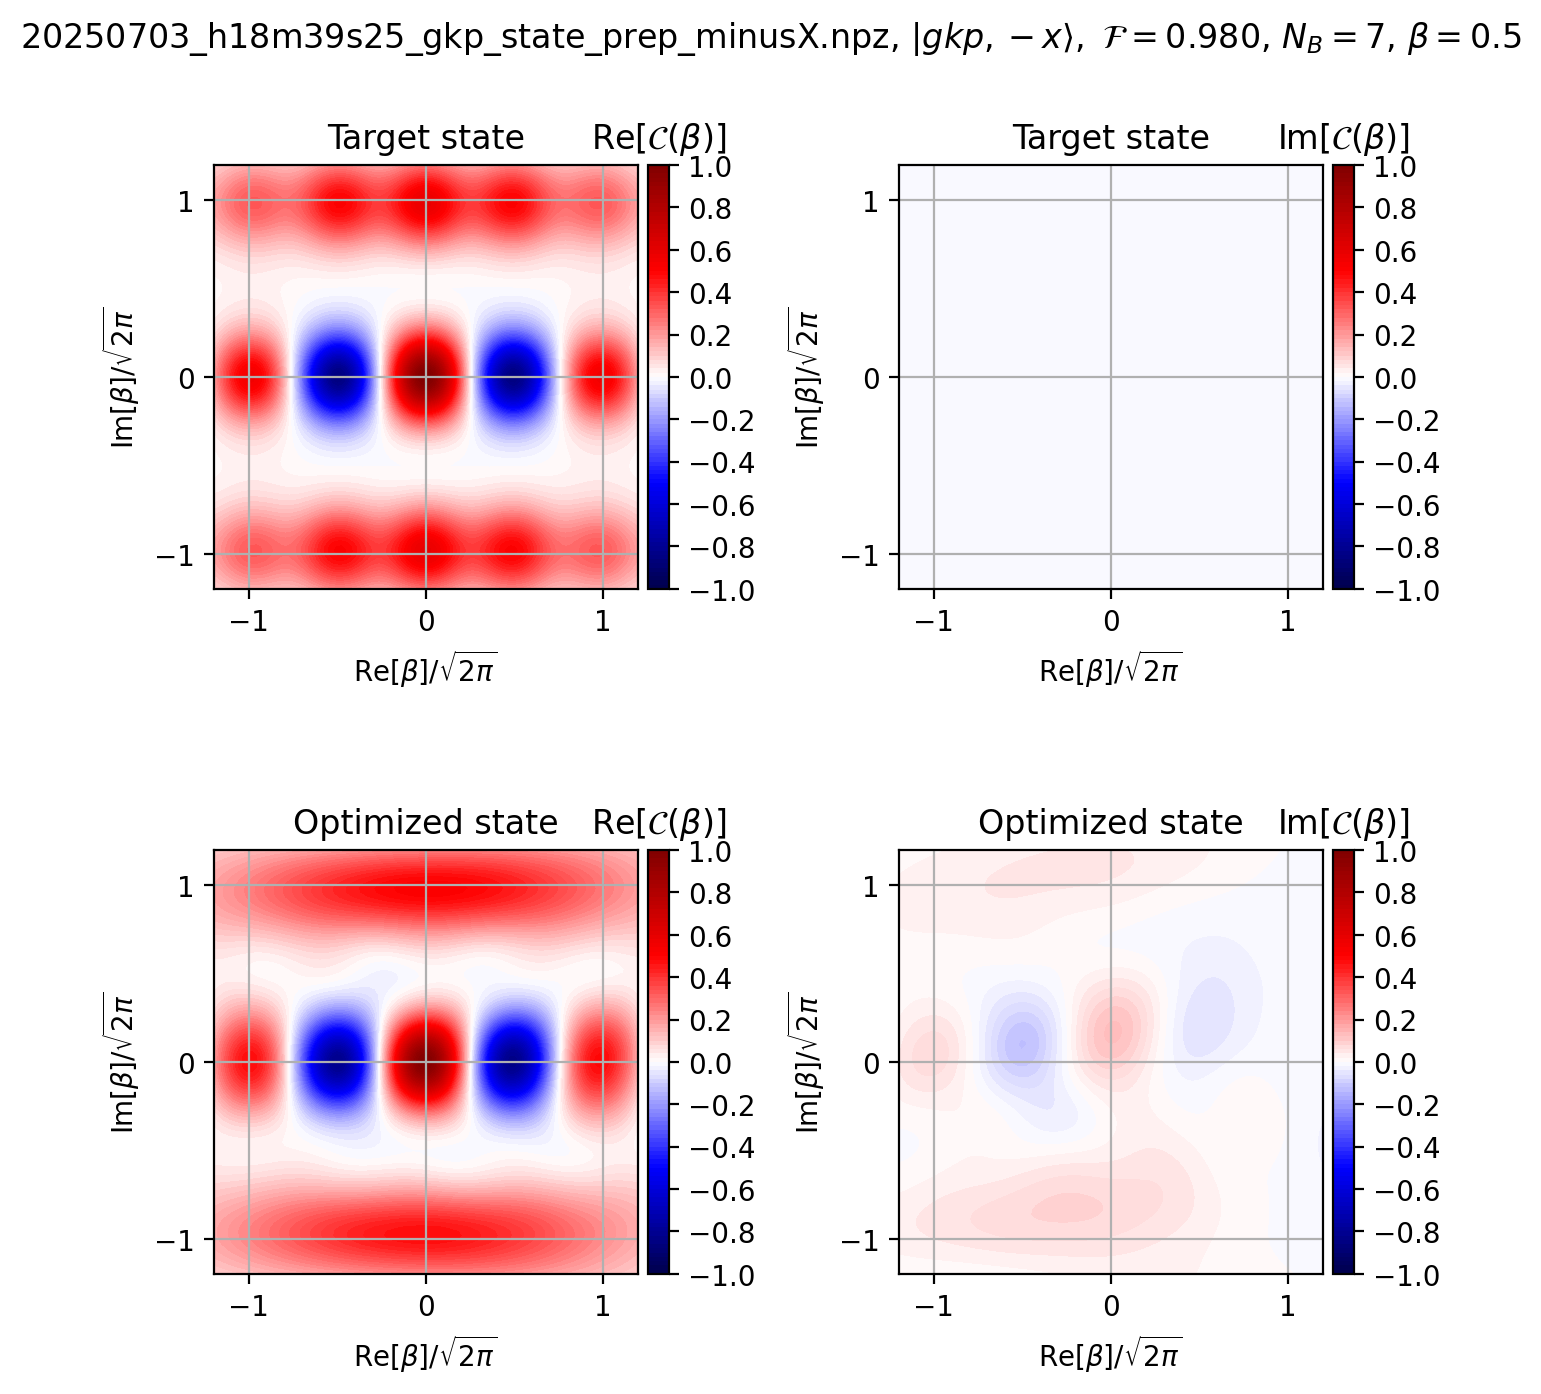

In [11]:
fig, axs = plt.subplots(2, 2, dpi=200, figsize=(7,7))
axs = axs.flatten()

print("Best parameters: \n", best_params)

N_large = settings["N_large"]
target_state_larger = jqt.basis(2,0) ^ generate_state(settings, large=True)

prepared_state = run_circuit_errors(best_params, N_large)
fid = jnp.real(jqt.overlap(target_state_larger, prepared_state)) 

betas_re = jnp.linspace(-3,3, 101)
betas_im = jnp.linspace(-3,3, 101)

# --------------------
# Target state
# --------------------
cf_vals, _, _ = sim_cf(settings["target_state"], betas_re, betas_im)

for j, ax in enumerate((axs[0], axs[1])):

    vmin = -1
    vmax = 1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(
        betas_re*sf,
        betas_im*sf,
        cf_vals_plot.T,
        levels=np.linspace(vmin, vmax, 101),
        cmap="seismic",
        vmin=vmin,
        vmax=vmax
    )

    ax.set_aspect("equal", adjustable="box")
    ax.grid()
    ax.set_xticks([-1,0,1])
    ax.set_yticks([-1,0,1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")
    ax.set_title("Target state")

    # Properly sized colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))


# --------------------
# Optimized state
# --------------------
cf_vals, _, _ = sim_cf(prepared_state, betas_re, betas_im)

for j, ax in enumerate((axs[2], axs[3])):

    vmin = -1
    vmax = 1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(
        betas_re*sf,
        betas_im*sf,
        cf_vals_plot.T,
        levels=np.linspace(vmin, vmax, 101),
        cmap="seismic",
        vmin=vmin,
        vmax=vmax
    )

    ax.set_aspect("equal", adjustable="box")
    ax.grid()
    ax.set_xticks([-1,0,1])
    ax.set_yticks([-1,0,1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")
    ax.set_title("Optimized state")

    # Properly sized colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))


fig.tight_layout()
fig.suptitle(
    f"{file_name}, $\\vert {settings['state']['mode']},{settings['state']['logical_state']}\\rangle,$ "
    f"$\\mathcal{{F}}={fid:.3f}$, $N_B={settings['blocks']}$, $\\beta={settings['reg_strength']}$",
    y=1.02
)
